<a href="https://colab.research.google.com/github/MattPlatt/S2GEN/blob/main/S2GEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/S2gen

/content/drive/MyDrive/S2gen


In [ ]:
# Install Detectron2 (it includes Mask R-CNN)
!pip install torch torchvision torchaudio
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git
# Install Tesseract OCR and pytesseract in a single command
!apt-get update && apt-get install -y tesseract-ocr && pip install pytesseract


In [4]:
import os
import cv2
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.model_zoo import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader




In [5]:
#NOTE: PATHS FOR TRAINING BELOW NEED TO HAVE DIFFERENT NAMES FOR EACH MODEL RUN. THIS HAS NOT BEEN DONE YET 12/26/24


# Import necessary libraries
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Paths to training and validation data
train_images_path = '/content/drive/MyDrive/S2gen/data/train/easy/images'
train_coco_annotations_file = '/content/drive/MyDrive/S2gen/data/train/easy/coco_annotations.json'
val_images_path = '/content/drive/MyDrive/S2gen/data/val/easy/images'
val_coco_annotations_file = '/content/drive/MyDrive/S2gen/data/val/easy/coco_annotations.json'

# Register the train and validation datasets
register_coco_instances("my_dataset_train", {}, train_coco_annotations_file, train_images_path)
register_coco_instances("my_dataset_val", {}, val_coco_annotations_file, val_images_path)

# Metadata for visualization (optional)
my_dataset_metadata = MetadataCatalog.get("my_dataset_train")


In [6]:
# Train the First Model on full images for blocks, connectors, modules, double boxes, dashed lines with arrows, etc..

import os
import cv2
import json
from detectron2.data import MetadataCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T

# Paths to images and COCO annotations file
images_path = '/content/drive/MyDrive/S2gen/data/train/easy/images'
coco_annotations_file = '/content/drive/MyDrive/S2gen/data/train/easy/coco_annotations.json'

# Register the dataset with COCO annotations
register_coco_instances("my_dataset", {}, coco_annotations_file, images_path)
my_dataset_metadata = MetadataCatalog.get("my_dataset")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset",)
cfg.DATASETS.TEST = ()  # No validation set for now
cfg.DATALOADER.NUM_WORKERS = 2

# Set to start training from scratch
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1/model_final.pth'



# Training configurations
cfg.SOLVER.IMS_PER_BATCH = 1  # Adjust batch size based on memory
cfg.SOLVER.BASE_LR = 0.00001  # Set base learning rate
cfg.SOLVER.MAX_ITER = 100  # Set max iterations for longer training

# ROI Heads configurations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Regions per image in training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # Only one class, 'dashed_line'


# Ensure anchor generator settings match the training configuration
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.05, 0.1, 0.2, 0.3]]

# Set input size for your images
cfg.INPUT.MIN_SIZE_TRAIN = 2176
cfg.INPUT.MAX_SIZE_TRAIN = 2752
cfg.INPUT.MIN_SIZE_TEST = 2176
cfg.INPUT.MAX_SIZE_TEST = 2752

# Set checkpoint saving every 500 iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# Define output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to include data augmentation
class AugmentedTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg,
            mapper=DatasetMapper(
                cfg,
                is_train=True,
                augmentations=[
                    T.RandomBrightness(0.8, 1.2),
                    T.RandomContrast(0.8, 1.2),
                    T.RandomRotation(angle=[-10, 10]),  # Small rotations
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                ],
            ),
        )

# Initialize and start training with augmentations
trainer = AugmentedTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/26 17:38:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/26 17:38:17 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/26 17:39:12 d2.utils.events]:  eta: 0:03:23  iter: 19  total_loss: 0.1767  loss_cls: 0.04374  loss_box_reg: 0.0674  loss_mask: 0.05369  loss_rpn_cls: 0.0004637  loss_rpn_loc: 0.01992    time: 2.5356  last_time: 2.5299  data_time: 0.0684  last_data_time: 0.0080   lr: 1.9081e-06  max_mem: 12353M
[12/26 17:40:03 d2.utils.events]:  eta: 0:02:23  iter: 39  total_loss: 0.1885  loss_cls: 0.04142  loss_box_reg: 0.06901  loss_mask: 0.05893  loss_rpn_cls: 0.0004476  loss_rpn_loc: 0.02143    time: 2.4600  last_time: 2.6373  data_time: 0.0109  last_data_time: 0.0261   lr: 3.9061e-06  max_mem: 12353M
[12/26 17:40:54 d2.utils.events]:  eta: 0:01:38  iter: 59  total_loss: 0.204  loss_cls: 0.0433  loss_box_reg: 0.06852  loss_mask: 0.05715  loss_rpn_cls: 0.0004879  loss_rpn_loc: 0.02046    time: 2.4805  last_time: 2.8486  data_time: 0.0128  last_data_time: 0.0095   lr: 5.9041e-06  max_mem: 12353M
[12/26 17:41:43 d2.utils.events]:  eta: 0:00:48  iter: 79  total_loss: 0.1903  loss_cls: 0.03107  loss_

In [7]:
# Run model on validation data. Using one imagefor simplified testing for now.

import os
import cv2
import json
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog

# Define custom class names
custom_class_names = ["Block", "Connector", "Double Connector", "Call Out", "Double Box",
                      "Call Out Circle", "Dashed Line with Arrow", "Module", "Cables"]

# Function to return a list of dictionaries for the dataset (dummy implementation for registration)
def get_custom_dataset():
    return []

# Register the custom dataset
custom_dataset_name = "custom_val_dataset"
if custom_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(custom_dataset_name)
    MetadataCatalog.remove(custom_dataset_name)

DatasetCatalog.register(custom_dataset_name, get_custom_dataset)
MetadataCatalog.get(custom_dataset_name).thing_classes = custom_class_names

# Paths
val_image_path = '/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png'
predictions_json_path_1 = '/content/drive/MyDrive/S2gen/runs/easy_predictions_1/predictions_1.json'
os.makedirs(os.path.dirname(predictions_json_path_1), exist_ok=True)

# Configure the first model
cfg1 = get_cfg()
cfg1.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg1.MODEL.WEIGHTS = '/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1/model_final.pth'
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = len(custom_class_names)
cfg1.INPUT.MIN_SIZE_TEST = 2176
cfg1.INPUT.MAX_SIZE_TEST = 2752

# Set the dataset metadata for the custom dataset
cfg1.DATASETS.TRAIN = (custom_dataset_name,)
cfg1.DATASETS.TEST = (custom_dataset_name,)

# Create predictor and load image
predictor1 = DefaultPredictor(cfg1)
image = cv2.imread(val_image_path)

# Run inference
outputs1 = predictor1(image)

# Prepare COCO-style JSON output
coco_annotations_1 = {
    "images": [{"file_name": os.path.basename(val_image_path), "height": image.shape[0], "width": image.shape[1], "id": 1}],
    "annotations": [],
    "categories": [{"id": i, "name": name} for i, name in enumerate(custom_class_names)]
}

# Convert Detectron2 predictions to COCO-style format
instances = outputs1["instances"].to("cpu")
for i in range(len(instances)):
    bbox = instances.pred_boxes[i].tensor.numpy().tolist()[0]
    category_id = int(instances.pred_classes[i].item())
    coco_annotations_1["annotations"].append({
        "id": i,
        "image_id": 1,
        "category_id": category_id,
        "bbox": [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],  # Convert to COCO bbox format
        "area": float((bbox[2] - bbox[0]) * (bbox[3] - bbox[1])),
        "iscrowd": 0
    })

# Save the JSON file for the first model's predictions
with open(predictions_json_path_1, 'w') as f:
    json.dump(coco_annotations_1, f)

print(f"First model predictions saved in COCO JSON format at: {predictions_json_path_1}")


[12/26 17:42:36 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

First model predictions saved in COCO JSON format at: /content/drive/MyDrive/S2gen/runs/easy_predictions_1/predictions_1.json


In [8]:
# Set Training and validation data for second model

# Paths to training and validation data
train_images_path2 = '/content/drive/MyDrive/S2gen/data/train/easy/sliced_images'
train_coco_annotations_file2 = '/content/drive/MyDrive/S2gen/data/train/easy/sliced_coco_annotations.json'
val_images_path2 = '/content/drive/MyDrive/S2gen/data/val/easy/sliced_images'
val_coco_annotations_file2 = '/content/drive/MyDrive/S2gen/data/val/easy/coco_annotations.json'

# Register the train and validation datasets
register_coco_instances("my_dataset_train2", {}, train_coco_annotations_file2, train_images_path2)
register_coco_instances("my_dataset_val2", {}, val_coco_annotations_file2, val_images_path2)

# Metadata for visualization (optional)
my_dataset_metadata = MetadataCatalog.get("my_dataset_train2")


In [9]:
# Train the second model on cables only

import os
import cv2
import json
from detectron2.data import MetadataCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T

# Paths to images and COCO annotations file
images_path = '/content/drive/MyDrive/S2gen/data/train/easy/sliced_images'
coco_annotations_file = '/content/drive/MyDrive/S2gen/data/train/easy/sliced_coco_annotations.json'




# Register the dataset with COCO annotations
register_coco_instances("my_dataset_train2", {}, coco_annotations_file, images_path)
my_dataset_metadata = MetadataCatalog.get("my_dataset_train2")


# Set up configuration
cfg3 = get_cfg()
cfg3.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg3.DATASETS.TRAIN = ("my_dataset_train2",)
cfg3.DATASETS.TEST = ()  # No validation set for now
cfg3.DATALOADER.NUM_WORKERS = 2

# Set to start training from scratch
cfg3.MODEL.WEIGHTS = "/content/drive/MyDrive/S2gen/runs/detect/MASK/r101_run2_scratch/model_0019999.pth"



# Training configurations
cfg3.SOLVER.IMS_PER_BATCH = 1  # Adjust batch size based on memory
cfg3.SOLVER.BASE_LR = 0.00001  # Set base learning rate
cfg3.SOLVER.MAX_ITER = 100  # Set max iterations for longer training

# ROI Heads configurations
cfg3.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Regions per image in training
cfg3.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class, 'dashed_line'


#Ensure anchor generator settings match the training configuration
cfg3.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]
cfg3.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.05, 0.1, 0.2, 0.3]]

# Set input size for your images
cfg3.INPUT.MIN_SIZE_TRAIN = 435
cfg3.INPUT.MAX_SIZE_TRAIN = 550
cfg3.INPUT.MIN_SIZE_TEST = 435
cfg3.INPUT.MAX_SIZE_TEST = 550



# Set checkpoint saving every 500 iterations
cfg3.SOLVER.CHECKPOINT_PERIOD = 500

# Define output directory
cfg3.OUTPUT_DIR = "/content/drive/MyDrive/S2gen/runs/detect/MASK/r101_run3_scratch/"
os.makedirs(cfg3.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to include data augmentation
class AugmentedTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg,
            mapper=DatasetMapper(
                cfg,
                is_train=True,
                augmentations=[
                    T.RandomBrightness(0.8, 1.2),
                    T.RandomContrast(0.8, 1.2),
                    T.RandomRotation(angle=[-10, 10]),  # Small rotations
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                ],
            ),
        )

# Initialize and start training with augmentations
trainer = AugmentedTrainer(cfg3)
trainer.resume_or_load(resume=False)
trainer.train()


[12/26 17:42:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/26 17:42:41 d2.engine.train_loop]: Starting training from iteration 0
[12/26 17:42:46 d2.utils.events]:  eta: 0:00:17  iter: 19  total_loss: 0.1883  loss_cls: 0.01971  loss_box_reg: 0.07431  loss_mask: 0.06602  loss_rpn_cls: 0.002942  loss_rpn_loc: 0.01657    time: 0.2136  last_time: 0.1696  data_time: 0.0161  last_data_time: 0.0048   lr: 1.9081e-06  max_mem: 12353M
[12/26 17:42:50 d2.utils.events]:  eta: 0:00:12  iter: 39  total_loss: 0.1789  loss_cls: 0.009451  loss_box_reg: 0.06867  loss_mask: 0.05673  loss_rpn_cls: 0.001435  loss_rpn_loc: 0.0156    time: 0.2002  last_time: 0.1564  data_time: 0.0035  last_data_time: 0.0026   lr: 3.9061e-06  max_mem: 12353M
[12/26 17:42:53 d2.utils.events]:  eta: 0:00:06  iter: 59  total_loss: 0.2174  loss_cls: 0.01692  loss_box_reg: 0.09736  loss_mask: 0.06854  loss_rpn_cls: 0.002223  loss_rpn_loc: 0.01088    time: 0.1884  last_time: 0.1821  data_time: 0.0030  last_data_time: 0.0031   lr: 5.9041e-06  max_mem: 12353M
[12/26 17:42:57 d2.utils.even

In [10]:
#Run second model on Cables only using  one sliced image. sliced images.Custom Anchor boxes used, should be adjusted for performance at a later date.
# Predictions saved in JSON with location data adjusted to true full image location.

import os
import cv2
import json
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from pycocotools import mask as mask_utils
import numpy as np

# Directory setup for sliced images and JSON output for the second model
sliced_images_folder = '/content/drive/MyDrive/S2gen/data/val/easy/sliced_images'
predictions_json_path_2 = '/content/drive/MyDrive/S2gen/runs/easy_predictions_2/predictions_2.json'
os.makedirs(sliced_images_folder, exist_ok=True)
os.makedirs(os.path.dirname(predictions_json_path_2), exist_ok=True)

# Slicing parameters
slice_width, slice_height = 550, 435
num_slices_width, num_slices_height = 7, 6
overlap_percentage_width, overlap_percentage_height = 0.25, 0.25

val_image_path = '/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png'

# Configure the second model
cfg2 = get_cfg()
cfg2.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg2.MODEL.WEIGHTS = "/content/drive/MyDrive/S2gen/runs/detect/MASK/r101_run2_scratch/model_0019999.pth"
cfg2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg2.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class, 'Cables'
cfg2.INPUT.MIN_SIZE_TEST = 435
cfg2.INPUT.MAX_SIZE_TEST = 550

# Ensure anchor generator settings match the training configuration
cfg2.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]
cfg2.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.05, 0.1, 0.2, 0.3]]

predictor2 = DefaultPredictor(cfg2)

# COCO-style JSON output for second model with category ID set for 'Cables'
coco_annotations_2 = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 8, "name": "Cable"}]  # Set category ID to 8 for 'Cables'
}

# Load the image and prepare slicing
image = cv2.imread(val_image_path)
original_height, original_width, _ = image.shape
step_width = int(slice_width * (1 - overlap_percentage_width))
step_height = int(slice_height * (1 - overlap_percentage_height))
annotation_id = 0

# Slice the image and run inference on each slice
for i in range(num_slices_height):
    for j in range(num_slices_width):
        x_start = j * step_width
        y_start = i * step_height
        x_end = min(x_start + slice_width, original_width)
        y_end = min(y_start + slice_height, original_height)

        # Slice and save image
        slice_img = image[y_start:y_end, x_start:x_end]
        slice_name = f"diagram_8001_{i}_{j}.png"
        slice_path = os.path.join(sliced_images_folder, slice_name)
        cv2.imwrite(slice_path, slice_img)

        # Run inference on the slice
        outputs2 = predictor2(slice_img)
        instances = outputs2["instances"].to("cpu")

        # Add slice info to JSON with a unique image_id for each slice
        image_id = i * num_slices_width + j + 1  # Unique ID for each slice
        coco_annotations_2["images"].append({
            "file_name": slice_name,
            "height": slice_img.shape[0],
            "width": slice_img.shape[1],
            "id": image_id
        })

        # Convert predictions to COCO-style annotations with adjusted coordinates
        for k in range(len(instances)):
            bbox = instances.pred_boxes[k].tensor.numpy().tolist()[0]
            mask = instances.pred_masks[k].numpy()
            encoded_mask = mask_utils.encode(np.asfortranarray(mask.astype(np.uint8)))
            encoded_mask["counts"] = encoded_mask["counts"].decode("utf-8")

            # Adjust bbox position to map to original image coordinates
            adjusted_bbox = [
                bbox[0] + x_start,  # Adjust x coordinate to full image
                bbox[1] + y_start,  # Adjust y coordinate to full image
                bbox[2] - bbox[0],  # Width remains the same
                bbox[3] - bbox[1]   # Height remains the same
            ]

            # Add adjusted annotations to the JSON
            coco_annotations_2["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,  # Correct unique image_id for each slice
                "category_id": 8,  # Set category_id to 8 for 'Cables'
                "bbox": adjusted_bbox,
                "segmentation": encoded_mask,
                "area": float(mask.sum()),
                "iscrowd": 0
            })
            annotation_id += 1

# Save JSON file for the second model's predictions
with open(predictions_json_path_2, 'w') as f:
    json.dump(coco_annotations_2, f)

print(f"Second model predictions saved in COCO JSON format at: {predictions_json_path_2}")


[12/26 17:43:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/S2gen/runs/detect/MASK/r101_run2_scratch/model_0019999.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Second model predictions saved in COCO JSON format at: /content/drive/MyDrive/S2gen/runs/easy_predictions_2/predictions_2.json


In [11]:
# Combine predictions from both models into one COCO JSON format file.


import json

# Load both JSON files
with open(predictions_json_path_1, 'r') as f1:
    coco_annotations_1 = json.load(f1)

with open(predictions_json_path_2, 'r') as f2:
    coco_annotations_2 = json.load(f2)

# Combine annotations and images
combined_annotations = {
    "images": coco_annotations_1["images"],  # Use the original image info
    "annotations": coco_annotations_1["annotations"] + coco_annotations_2["annotations"],
    "categories": coco_annotations_1["categories"]
}

# Save the combined JSON file
combined_json_path = "/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json"
os.makedirs(os.path.dirname(combined_json_path), exist_ok=True)
with open(combined_json_path, 'w') as f:
    json.dump(combined_annotations, f)

print(f"Combined predictions saved in COCO JSON format at: {combined_json_path}")


Combined predictions saved in COCO JSON format at: /content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json


In [12]:
# Attach predictions to image for visualization.

import os
import cv2
import json
import numpy as np
from pycocotools import mask as mask_utils

# Paths
original_image_path = '/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png'
combined_json_path = '/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json'
output_dir = '/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/annotated_image'
os.makedirs(output_dir, exist_ok=True)

# Load the original image
original_image = cv2.imread(original_image_path)

# Load combined predictions
with open(combined_json_path, 'r') as f:
    combined_predictions = json.load(f)

# Overlay each annotation on the original image
for annotation in combined_predictions['annotations']:
    # Get the bounding box and category
    bbox = annotation['bbox']
    x_start, y_start, width, height = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    category_id = annotation['category_id']

    # Draw the bounding box
    color = (0, 255, 0)  # Green for bounding boxes
    cv2.rectangle(original_image, (x_start, y_start), (x_start + width, y_start + height), color, 2)

    # Draw the category label above the bounding box
    label = combined_predictions['categories'][category_id]['name']
    cv2.putText(original_image, label, (x_start, y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw segmentation mask if available
    if 'segmentation' in annotation:
        segmentation = annotation['segmentation']
        if isinstance(segmentation, dict):  # RLE format
            mask = mask_utils.decode(segmentation).astype(np.uint8) * 255  # Decode the RLE mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(original_image, contours, -1, (255, 0, 0), 2)  # Blue for masks
        elif isinstance(segmentation, list):  # Polygon format
            for seg in segmentation:
                poly = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.polylines(original_image, [poly], isClosed=True, color=(255, 0, 0), thickness=2)

# Save the annotated image
output_image_path = os.path.join(output_dir, 'diagram_8001_annotated.png')
cv2.imwrite(output_image_path, original_image)

print(f"Annotated image saved at: {output_image_path}")


Annotated image saved at: /content/drive/MyDrive/S2gen/runs/easy_predictions_combined/annotated_image/diagram_8001_annotated.png


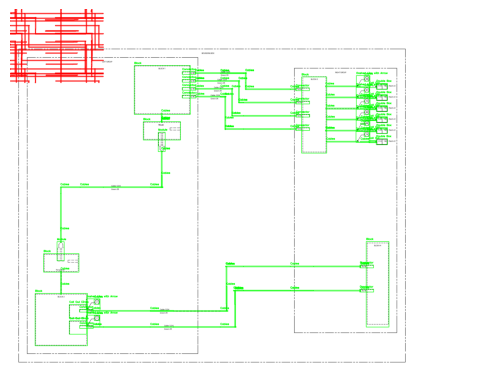

In [13]:
#Print image for visulization

import matplotlib.pyplot as plt
import cv2

# Load an image using OpenCV (use the correct path to your image)
image = cv2.imread('/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/annotated_image/diagram_8001_annotated.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()


In [14]:
# Convert predictions to SysML 2.0.

import json
import cv2
import numpy as np
import pytesseract

# Load the combined predictions JSON file
combined_json_path = '/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json'
with open(combined_json_path, 'r') as f:
    predictions = json.load(f)

# Load the image to extract text from blocks
image_path = "/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png"  # Update with the correct path
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

import cv2
import pytesseract
import numpy as np

import cv2
import pytesseract
import numpy as np

import cv2
import pytesseract
import numpy as np

def extract_text_from_bbox(image, bbox):
    # Use the full bounding box dimensions
    x, y, w, h = map(int, bbox)

    # Focus only on the top 20% of the bounding box
    top_section_height = int(h * 0.2)
    cropped_image = image[y:y + top_section_height, x:x + w]

    # Convert to grayscale
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Apply resizing (magnification) to enhance OCR performance
    magnified_image = cv2.resize(gray, None, fx=4.0, fy=4.0, interpolation=cv2.INTER_CUBIC)

    # Apply adaptive thresholding to improve text clarity
    thresh = cv2.adaptiveThreshold(magnified_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # OCR configuration focused on capturing single lines or words
    custom_config = r'--psm 7 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-'
    text = pytesseract.image_to_string(thresh, config=custom_config).strip()

    return text



# Initialize SysML part definitions and interface connections
block_parts = []
module_parts = []
connector_parts = []
cable_parts = []
interface_connections = []

# Define mappings for category IDs to names (use class names from your model)
category_id_to_name = {
    0: 'Block',
    1: 'Connector',
    2: 'Double Connector',
    3: 'Cable',
    4: 'Dashed Line with Arrow',
    5: 'Module',
    6: 'Double Box',
    7: 'Call Out',
    8: 'Cables',
    9: 'Double Connector',
    10: 'Call Out Circle',
}

# Organize parts based on categories
for annotation in predictions["annotations"]:
    category_name = category_id_to_name.get(annotation["category_id"], None)
    part_id = f"{category_name.lower()}{annotation['id']}"

    if category_name == "Block":
        # Extract text only for blocks
        block_name = extract_text_from_bbox(image, annotation["bbox"])
        block_parts.append(f"part {part_id}: Block {{ attribute name = \"{block_name}\"; }}")
    elif category_name == "Module":
        module_parts.append(f"part {part_id}: Module;")
    elif category_name == "Connector":
        connector_parts.append(f"part {part_id}: Connector;")
    elif category_name == "Cable":
        cable_parts.append(f"part {part_id}: Cable {{ attribute id = {annotation['id']}; }};")

# Generate connections based on SysML rules
def boxes_touch(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

for cable in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Cable"]:
    for other_cable in [ann for ann in predictions["annotations"] if ann["id"] != cable["id"] and category_id_to_name.get(ann["category_id"]) == "Cable"]:
        if boxes_touch(cable["bbox"], other_cable["bbox"]):
            interface_connections.append(f"interface sameCableConnection: BinaryInterface connect cable{cable['id']} to cable{other_cable['id']} using Cable;")

    for connector in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Connector"]:
        if boxes_touch(cable["bbox"], connector["bbox"]):
            interface_connections.append(f"interface cableConnectorConnection: BinaryInterface connect cable{cable['id']} to connector{connector['id']} using Cable;")

for connector in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Connector"]:
    for block in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Block"]:
        if boxes_touch(connector["bbox"], block["bbox"]):
            interface_connections.append(f"interface blockConnectorConnection: BinaryInterface connect connector{connector['id']} to block{block['id']} using Connector;")

    for module in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Module"]:
        if boxes_touch(connector["bbox"], module["bbox"]):
            interface_connections.append(f"interface moduleConnectorConnection: BinaryInterface connect connector{connector['id']} to module{module['id']} using Connector;")

for module in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Module"]:
    for block in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Block"]:
        if boxes_touch(module["bbox"], block["bbox"]):
            interface_connections.append(f"interface moduleBlockConnection: BinaryInterface connect module{module['id']} to block{block['id']} using Module;")

for dashed_line in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Dashed Line with Arrow"]:
    for cable in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Cable"]:
        combined_bbox = [
            min(dashed_line["bbox"][0], cable["bbox"][0]),
            min(dashed_line["bbox"][1], cable["bbox"][1]),
            max(dashed_line["bbox"][2] + dashed_line["bbox"][0], cable["bbox"][2] + cable["bbox"][0]) - min(dashed_line["bbox"][0], cable["bbox"][0]),
            max(dashed_line["bbox"][3] + dashed_line["bbox"][1], cable["bbox"][3] + cable["bbox"][1]) - min(dashed_line["bbox"][1], cable["bbox"][1])
        ]

        for block in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Block"]:
            if boxes_touch(combined_bbox, block["bbox"]):
                interface_connections.append(f"interface dashedLineBlockConnection: BinaryInterface connect dashedlinewitharrow{dashed_line['id']} to block{block['id']} using DashedLineWithArrow;")

    for double_box in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Double Box"]:
        if boxes_touch(dashed_line["bbox"], double_box["bbox"]):
            interface_connections.append(f"interface dashedLineDoubleBoxConnection: BinaryInterface connect dashedlinewitharrow{dashed_line['id']} to doublebox{double_box['id']} using DashedLineWithArrow;")

# Compile SysML code
sysml_code = "package ConnectionExample {\n\n"
sysml_code += "    // Part definitions for Blocks, Modules, Connectors, and Cables\n"
sysml_code += "    " + "\n    ".join(block_parts + module_parts) + "\n\n"
sysml_code += "    // Connector definitions\n"
sysml_code += "    " + "\n    ".join(connector_parts) + "\n\n"
sysml_code += "    // Cable parts with unique identifiers\n"
sysml_code += "    " + "\n    ".join(cable_parts) + "\n\n"
sysml_code += "    // Interface definitions for connections between parts\n"
sysml_code += "    " + "\n    ".join(interface_connections) + "\n\n"
sysml_code += "}\n"

# Save SysML output to a file
sysml_output_path = '/content/drive/MyDrive/S2gen/runs/easy_sysml2_output.txt'
with open(sysml_output_path, 'w') as f:
    f.write(sysml_code)

print(f"SysML code saved at: {sysml_output_path}")


SysML code saved at: /content/drive/MyDrive/S2gen/runs/easy_sysml2_output.txt


In [16]:
file_path = '/content/drive/MyDrive/S2gen/runs/easy_sysml2_output.txt'

# Open and read the file
with open(file_path, 'r') as file:
    content = file.read()

# Print the content
print(content)


package ConnectionExample {

    // Part definitions for Blocks, Modules, Connectors, and Cables
    part block27: Block { attribute name = ""; }
    part block35: Block { attribute name = ""; }
    part block36: Block { attribute name = ""; }
    part block38: Block { attribute name = ""; }
    part block41: Block { attribute name = ""; }
    part block47: Block { attribute name = "L BLOCK-3"; }
    part module46: Module;
    part module48: Module;

    // Connector definitions
    part connector0: Connector;
    part connector1: Connector;
    part connector2: Connector;
    part connector8: Connector;
    part connector10: Connector;
    part connector18: Connector;
    part connector21: Connector;
    part connector22: Connector;
    part connector24: Connector;
    part connector34: Connector;
    part connector44: Connector;
    part connector45: Connector;

    // Cable parts with unique identifiers
    part cable9: Cable { attribute id = 9; };
    part cable16: Cable { attribut